In [18]:
from random import random
import numpy as np
from scipy.ndimage import measurements
import statistics
import pandas as pd


L = 20

prob = .50

rng = np.random.RandomState()

def random_world(prob, L):
        return rng.choice([1, 0], size=(L, L), p=[prob, 1 - prob])

arr = random_world(prob, L)

## given cell and current count, find any tree neighbors, if there are, go to that neighbor, increment 1

def count_neighbors(cell_row, cell_col, size, world_arr, boolean_mat = None):
    if boolean_mat is None:
        boolean_mat = np.zeros((size, size))
    if (0 <= cell_row < size) and (0 <= cell_col < size) and (world_arr[cell_row][cell_col] == 1) and (boolean_mat[cell_row][cell_col] == 0):
        boolean_mat[cell_row][cell_col] = 1
        count_neighbors(cell_row + 1, cell_col, size, world_arr, boolean_mat)  
        count_neighbors(cell_row - 1, cell_col, size, world_arr, boolean_mat)  
        count_neighbors(cell_row, cell_col + 1, size, world_arr, boolean_mat)   
        count_neighbors(cell_row, cell_col - 1, size, world_arr, boolean_mat)   
    return np.sum(boolean_mat)

def get_max_cluster(arr):
    L = max(arr.shape)
    all_clusters = [count_neighbors(row, col, L, arr) for row in range(L) for col in range(L)]
    return max(all_clusters)

def get_max_cluster_scipy(arr):
    lw, num = measurements.label(arr)
    area = measurements.sum(arr, lw, index=np.arange(lw.max() + 1))
    return np.max(area)

def get_distr_cluster_size(arr):
    lw, num = measurements.label(arr)
    area = measurements.sum(arr, lw, index=np.arange(lw.max() + 1))/(arr.shape[0]**2)
    bins = np.arange(0, 1, .05)
    bin_means = np.histogram( area,
        bins= bins,
        density=False)[0]
    bin_means = [(mean, bin) for mean, bin in zip(bin_means, bins)]
    return bin_means
   # return area

def get_distr_cluster_rank_size(arr):
    lw, num = measurements.label(arr)
    area = measurements.sum(arr, lw, index=np.arange(lw.max() + 1))
    area_df = pd.DataFrame({"area": area})
    area_df["rank"] = area_df["area"].rank(ascending=False) 
    return area_df
   # return area


In [22]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [3]:
Ls = [20, 50, 100, 200 ,500, 1000, 2000][::-1]
ps = np.arange(0, 1, .01)[1:]

n_trials = 100

Ls

[2000, 1000, 500, 200, 100, 50, 20]

In [3]:
from collections import defaultdict
import time
from tqdm import tqdm

results = defaultdict(list)

for L in Ls:
    startTime = time.time()
    for p in tqdm(ps):
        for i in range(n_trials):
            arr = random_world(p, L)
            result = get_max_cluster_scipy(arr)
            results["size"].append(L)
            results["prob"].append(p)
            results["trial"].append(i)
            results["result"].append(result)
    executionTime = (time.time() - startTime)
    print(f'{L} Execution time in seconds: ' + str(executionTime))

  0%|          | 0/99 [00:00<?, ?it/s]/tmp/ipykernel_329/685860155.py:36: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  lw, num = measurements.label(arr)
/tmp/ipykernel_329/685860155.py:37: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  area = measurements.sum(arr, lw, index=np.arange(lw.max() + 1))
  0%|          | 0/99 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [173]:
import pandas as pd

results_df = pd.DataFrame.from_dict(results)

results_df.to_csv("2dpercolation_simulation.csv")


In [10]:
import pandas as pd


results_df = pd.read_csv("2dpercolation_simulation.csv")

results_df["frac_size"] = results_df["result"] / (results_df["size"]*results_df["size"])

In [11]:
results_df

,Unnamed: 0,size,prob,trial,result,frac_size
0,0,2000,0.01,0,4.0,1.000000e-06
1,1,2000,0.01,1,3.0,7.500000e-07
2,2,2000,0.01,2,4.0,1.000000e-06
3,3,2000,0.01,3,3.0,7.500000e-07
4,4,2000,0.01,4,3.0,7.500000e-07
...,...,...,...,...,...,...
69295,69295,20,0.99,95,395.0,9.875000e-01
69296,69296,20,0.99,96,394.0,9.850000e-01
69297,69297,20,0.99,97,395.0,9.875000e-01
69298,69298,20,0.99,98,394.0,9.850000e-01


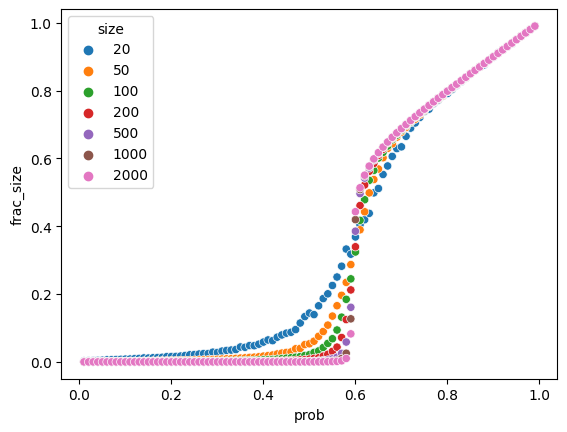

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df_avgd = results_df.groupby(["size", "prob"]).agg({"frac_size": "mean"}).reset_index()
results_df_avgd["size"] = results_df_avgd["size"].apply(lambda x: str(x))
sns.scatterplot(x = "prob", y = "frac_size", hue = "size", data = results_df_avgd)

plt.savefig("frac_size_prob.png")

In [183]:
results_df_avgd.query("size == '1000'").query(" .50 <= prob <= .63")

,size,prob,frac_size
544,1000,0.50,0.59068
545,1000,0.51,0.75622
546,1000,0.52,0.98075
547,1000,0.53,1.30519
548,1000,0.54,1.84393
549,1000,0.55,2.77706
550,1000,0.56,4.69484
551,1000,0.57,10.01205
552,1000,0.58,25.61736
553,1000,0.59,127.02743


In [15]:
from collections import defaultdict
from tqdm import tqdm
import itertools
n_trials = 100

def run_plot(prob, size):
    results_b = defaultdict(list)
    for i in tqdm(range(n_trials)):
        arr = random_world(prob, size)
        results = get_distr_cluster_size(arr)
        results_b["result"].append(results)
    result_together = list(itertools.chain.from_iterable(results_b["result"])) 
    results_b_df = pd.DataFrame.from_records(result_together, columns = ["count", "bin"])
    results_b_df_agg = results_b_df.groupby(["bin"]).agg({"count": "mean"}).reset_index()
    results_b_df_agg["prob"] = prob
    return results_b_df_agg

def run_plot_rank_size(prob, size):
    results_b = []
    for i in tqdm(range(n_trials)):
        arr = random_world(prob, size)
        results = get_distr_cluster_rank_size(arr)
        results_b.append(results)
    results_b_df = pd.concat(results_b)
    results_b_df_agg = results_b_df.groupby(["rank"]).agg({"area": "mean"}).reset_index()
    results_b_df_agg["prob"] = prob
    return results_b_df_agg

In [40]:
pc = .6

pcs = [pc/2, pc, pc + (1 - pc)/2]

results = [run_plot_rank_size(p, 1000) for p in pcs]

results_df = pd.concat(results).reset_index(drop = True)
  

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_338/1178179167.py:54: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  lw, num = measurements.label(arr)
/tmp/ipykernel_338/1178179167.py:55: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  area = measurements.sum(arr, lw, index=np.arange(lw.max() + 1))
/tmp/ipykernel_338/1178179167.py:54: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  lw, num = measurements.label(arr)
/tmp/ipykernel_338/1178179167.py:55: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  area = measurements.sum(arr, lw, index=np.arange(lw.max() + 1))
/tmp/ipykernel_338/1178179167.py:54: DeprecationWarning: Please use `label` from 

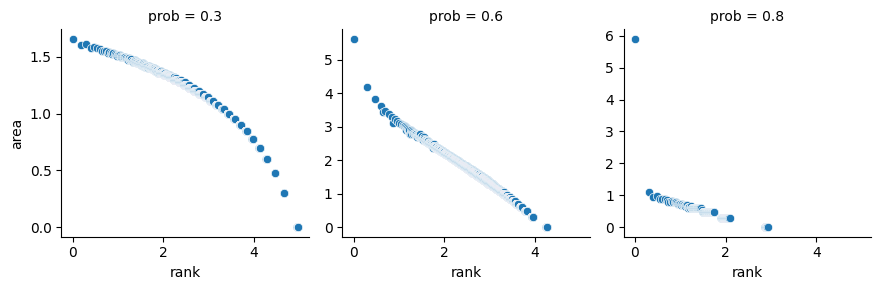

In [41]:
import seaborn as sns
import math

results_df = results_df.query("rank > 0 and area > 0")

results_df["rank"] = results_df["rank"].apply(lambda x: math.log10(x))
results_df["area"] = results_df["area"].apply(lambda x: math.log10(x))

g = sns.FacetGrid(results_df, col="prob", sharey = False)
g.map_dataframe(sns.scatterplot, x="rank", y = "area", alpha = 1)
g.savefig("distr_by_pc.png")